<a href="https://colab.research.google.com/github/dan-kwon/doubly-robust-estimators/blob/main/doubly_robust_estimators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exploring Doubly Robust Estimators

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression

### Conceptual Overview

**Doubly Robust Estimators** combine two causal inference methods in order to estimate the true treatment effect, controlling for any confounding that may exist. 
<br>
<br>
The first component is a model that estimates the outcome of interest, taking into consideration any covariates, confounders, and exposure to treatment. In this model, the coefficient of the treatment variable would represent the causal relationship between an exposure to treatment and the outcome of interest.

<p style="text-align: center;">
$ATE = \frac{E(Y | X, W, T = 0)}{E(Y | X, W, T = 1)}-1$
</p>
<br>
The second component is a model that estimates the likelihood of exposure to treatment (i.e. propensity score). Once a subject's propensity scores are determined, weighng by propensity scores creates a pseudo test and control group that can be analyzed as if the treatment was assigned randomly.
<br>
<br>
If specified correctly, either of these component model would accurately estimate true treatment effects. However, if misspecified both models fail individually. A doubly robust model combines the two component models so that if either models are correctly specified, the resulting estimates of treatment effect still hold true. This notebook will walk through examples of the two component models individually, explore the results from correctly specified and misspecified models, and combine both models to create a doubly robust estimator to illustrate its advantages.

### DAG

The causal relationships between our variables are outlined below. In practice, understanding causal relationships of all relevant variables requires significant subject matter expertise, but we get the benefit of being to create our own data in this exercise. Our variables are listed below:

| **Name** | **Description** |
| --- | --- |
| $Y$ | Outcome of interest (Numeric) |
| $X1$ | Covariate of Y (Numeric) |
| $X2$ | Covariate of T (Numeric) |
| $W$ | Confounder (Numeric) |
| $T$ | Treatment (1 or 0) |


And our resulting DAG

In [ ]:
from graphviz import Source
from IPython.core.magic import register_cell_magic

@register_cell_magic
def graph(line, cell):
  src = "digraph {%s}" % cell
  g = Source(src)
  if line:
    name = line.split()[0]
    globals()[name] = g
  else:
    return g

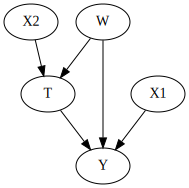

In [ ]:
%%graph 
  subgraph {
    X2 -> T
    W -> T
  }
  subgraph {
    X1 -> Y
    T -> Y
    W -> Y
  }

### Generating Data

We generate a dataset with known properties so that we know what the true treatment effect that we are trying to estimate should be.

<p style="text-align: center;">
$X1\ and\ Y \sim N(5, 1.25)$ and $\rho_{xy} = 0.75$ <br>
$X2 \sim Beta(3,5)$ <br>
$W \sim Beta(2,5)$ <br>
$T \sim Bernoulli(p = \frac{X2+W}{2})$ <br>
</p>

In [ ]:
def generate_data_fn(seed = 123456, nrow = 100000):
  
  rng = np.random.default_rng(seed)

  # generate X1 and Y from mvn distribution
  mean = [5, 5]
  sd   = [1.25, 1.25]
  rho  = 0.75
  cov = [[sd[0]**2, rho*sd[0]*sd[1]], 
        [rho*sd[0]*sd[1], sd[1]**2]]
  mvn = rng.multivariate_normal(mean, cov, nrow)
  X1 = mvn[:,0]
  Y = mvn[:,1]

  # generate confounder
  W = rng.beta(30, 70, nrow)

  # assign treatment 1 or 0 based on W
  T = rng.binomial(1, W, nrow)

  # back into X2, a covariate for T used to create propensity scores
  X2 = rng.normal((T*2)+10, 1, nrow)

  # define treatment effect
  TE = Y * T * rng.normal(1.15,0.02,nrow)

  # define confounding effect
  CE = Y * rng.normal(W,0.05,nrow)

  # add TE and CE to Y
  Y = Y + TE + CE

  # combine in df
  data = {'Y'  : Y,
          'X1' : X1,
          'X2' : X2, 
          'W'  : W,
          'T'  : T}
  df = pd.DataFrame(data)
  df['T'] = df['T'].apply(str)

  return df

In [ ]:
df = generate_data_fn()

Text(0.5, 1.0, 'Fig 6')

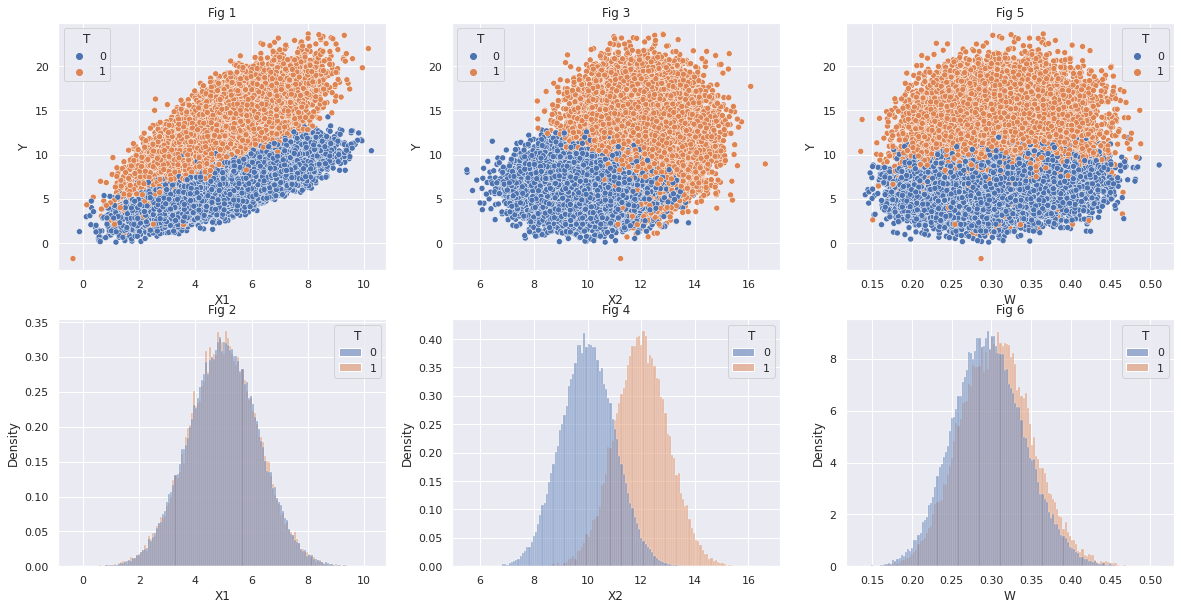

In [ ]:
sns.set(rc={'figure.figsize':(20,10)})
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharey=False)

sns.scatterplot(data=df,
                x='X1',
                y='Y',
                hue='T',
                ax=ax1)
ax1.set_title("Fig 1")

sns.histplot(data=df,
             x='X1',
             hue='T',
             stat='density',
             common_norm=False,
             ax=ax4)
ax4.set_title("Fig 2")

sns.scatterplot(data=df,
                x='X2',
                y='Y',
                hue='T',
                ax=ax2)
ax2.set_title("Fig 3")

sns.histplot(data=df,
             x='X2',
             hue='T',
             stat='density',
             common_norm=False,
             ax=ax5)
ax5.set_title("Fig 4")

sns.scatterplot(data=df,
                x='W',
                y='Y',
                hue='T',
                ax=ax3)
ax3.set_title("Fig 5")

sns.histplot(data=df,
             x='W',
             hue='T',
             stat='density',
             common_norm=False,
             ax=ax6)
ax6.set_title("Fig 6")

### Outcome Model

Now that we have our dummy dataset, let's start with a **correctly specified outcome model**.
<br>
<br>
We know that the true treatment effect is a 12% increase in $Y$, our only confounder is $W$, and our only covariate is $X1$. We should expect a model that includes $W$, $X1$, and $T$ will return an accurate estimate of our treatment effect. Note that our treatment effect is multiplicative so we use an interaction term between $T$ and $X1$ to represent our treatment effect.

In [ ]:
def train_outcome_model_fn(data, X_col):
  data_copy = data.copy()
  # include interaction terms because TE is a multiplicative effect while X1 and W are additive
  poly = PolynomialFeatures(interaction_only=True, include_bias=False)
  data_copy = pd.DataFrame(data = poly.fit_transform(data_copy[X_col]), columns = poly.get_feature_names_out(X_col))
  data_copy['Y'] = data['Y']
  # fit LR on W, X1, and X1*T
  lr = LinearRegression()
  lr.fit(data_copy[[x for x in X_col if x not in 'T'] + ['X1 T']], data_copy['Y'])
  return lr

In [ ]:
df = generate_data_fn()
X_col = ['X1','W','T']
lr = train_outcome_model_fn(df, X_col)
pd.DataFrame(data={'coeff' : lr.coef_, 'name' : lr.feature_names_in_})

,coeff,name
0,0.893063,X1
1,4.981485,W
2,1.137251,X1 T


The results from our correctly specified outcome model is as expected. The coefficient of the interaction term is 1.126, implying that for every unit increase in $X1$ (our covariate), there is a 12.6% increase in $Y$ for $T=1$.

What about in the case of a **misspecified outcome model**?
<br>
<br>
Recall from the *Generating Data* section that $X2$ only impacts $T$ but because $T$ impacts $Y$, it could be erroneously labeled as a confounder. What happens to our estimates of treatment effect then?


In [ ]:
X_col = ['X1','T']
lr = train_outcome_model_fn(df, X_col)
pd.DataFrame(data={'coeff' : lr.coef_, 'name' : lr.feature_names_in_})

,coeff,name
0,0.890546,X1
1,1.146510,X1 T


If we fail to control for our confounder $W$, our model overestimates the TE by almost 50% or 6% pts. Conceptually, this makes sense as well; $W$ has a positive effect on $Y$ and failing to control for it has our model inaccurately combining $W$'s impacts with the actual treatment effect.
<br>
<br>
Without correctly specifying the outcome model, the results quickly fall apart.

### Propensity Model

The second part of a doubly robust estimator is an propensity model that estimates the likelihood of exposure to treatment. Commonly, propensity scores are used to create an inverse probability of treatment weight, which can be used to weight subjects accordingly to create a pseudo test and control population.
<br>
<br>
For our propensity model, we know that $W$ and $X2$ are the only factors that influences the likelihood that $T=1$.

In [ ]:
def train_propensity_model_fn(data, X_col):
  # create copy of dataframe
  data_copy = data.copy()
  # train model
  clf = LogisticRegression(penalty='none')
  clf.fit(data_copy[X_col], data_copy['T'])
  
  return clf

In [ ]:
def plot_IPTW_fn(data, clf):
  # copy data
  data_copy=data.copy()
  # predict propensity
  data_copy['PS'] = clf.predict_proba(data_copy[X_col])[:,1]
  # calc IPTW weights
  data_copy['weights'] = 1/(data_copy['PS'])
  data_copy.loc[data_copy['T']=='0', 'weights'] = 1/(1-data_copy['PS'])
  # plots
  sns.set(rc={'figure.figsize':(15,5)})
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False)
  sns.histplot(data=data_copy,
               x='PS',
               hue='T',
               stat='density',
               common_norm=False,
               ax=ax1)
  ax1.set(title='Propensity Score')
  sns.histplot(data=data_copy,
              x='W',
              hue='T',
              stat="probability",
              common_norm = False,
              common_bins = True,
              bins=50,
              ax=ax2)
  ax2.set(title='Before IPTW')
  sns.histplot(data=data_copy,
              x='W',
              hue='T',
              weights='weights',
              stat="probability",
              common_norm = False,
              common_bins = True,
              bins=50,
              ax=ax3)
  ax3.set(title='After IPTW')

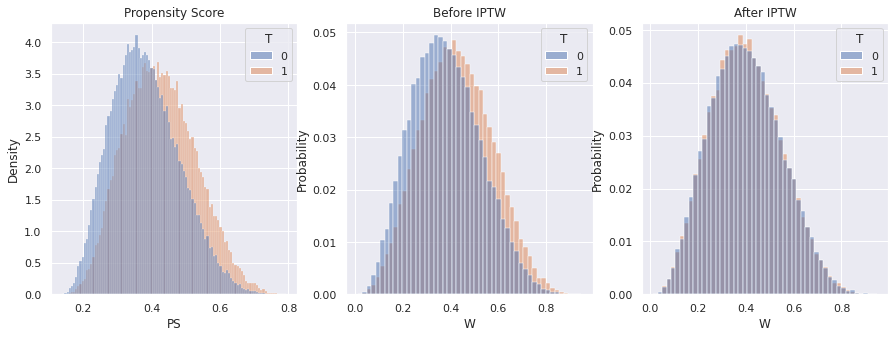

In [ ]:
# get fresh data
df = generate_data_fn()
# create propensity scores
X_col = ['W','X2']
clf = train_propensity_model_fn(df, X_col)
plot_IPTW_fn(df, clf)

With our propensity scores, we calculate each subject's inverse probability of treatment weighting as $1/PS$ for treated subjects and $1/(1-PS)$ for our untreated subjects.  
  
Once we weight subjects by their IPTWs, we can see the distribution of our confounder $W$ between our pseudo treatment and control group is more similar than the distributions before weighting. If the distribution of a confounding variable is similar between treatment and control groups, the confounder has effectively been controlled for.

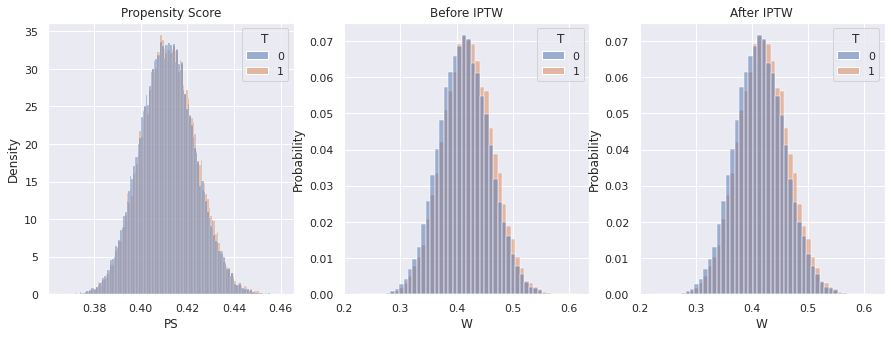

In [ ]:
# create propensity scores
X_col = ['X2']
clf = train_propensity_model_fn(df, X_col)
plot_IPTW_fn(df, clf)

If we misspecify our propensity model, we can see that results post-IPTW still show a significant difference in distributions of $W$ across the treated and untreated populations.

### Doubly Robust Estimator

Finally, we put it all together to create a doubly robust estimator. To do so, we calculate the expected response under exposure to treatment and the expected response under non-exposure using formulas below.
<br>
<br>

| &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | **DR Estimate when T = 1** &nbsp; | **DR Estimate when T = 0** &nbsp; |
| --- | :---: | :---: |
| $T = 1$ | $\frac{Y_{T=1}T}{PS}-\frac{\hat{Y_1}(T-PS)}{PS}$ | $\hat{Y_0}$ |
| $T = 0$ | $\hat{Y_1}$ | $\frac{Y_{T=0}(1-T)}{1-PS}-\frac{\hat{Y_0}(T-PS)}{1-PS}$ |


In [ ]:
def DR_fn(data, outcome_model, propensity_model):
  X_outcome_col = [i for i in outcome_model.feature_names_in_]
  X_propensity_col = [i for i in propensity_model.feature_names_in_]
  # append propensity scores to dataframe
  data['PS'] = propensity_model.predict_proba(data[X_propensity_col])[:,1]
  # append Yhat_0 values to dataframe
  data_0 = data[[i for i in outcome_model.feature_names_in_ if 'T' not in i]].copy()
  data_0['X1 T'] = data_0['X1'] * 0
  data['Yhat_0'] = outcome_model.predict(data_0[X_outcome_col])
  # repeat for Yhat_1
  data_1 = data[[i for i in outcome_model.feature_names_in_ if 'T' not in i]].copy()
  data_1['X1 T'] = data_1['X1'] * 1
  data['Yhat_1'] = outcome_model.predict(data_1[X_outcome_col])
  # calculate doubly robust estimates
  def DR1_fn(row):
    if row['T'] == 1:
      DR_1 = row['Y']/row['PS'] - (row['Yhat_1']*(1-row['PS']))/row['PS']
    else:
      DR_1 = row['Yhat_1']
    return DR_1
  def DR0_fn(row):
    if row['T'] == 1:
      DR_0 = row['Yhat_0']
    else:
      DR_0 = row['Y']/(1-row['PS']) - (row['Yhat_0']*row['PS'])/(1-row['PS'])
    return DR_0
  
  data['DR_1'] = data.apply(DR1_fn, axis=1)
  data['DR_0'] = data.apply(DR0_fn, axis=1)
  
  return data

Both models correctly specified

In [ ]:
# get fresh data
df = generate_data_fn()

# create our outcome model
X_col_1 = ['X1','W','T']
outcome_model = train_outcome_model_fn(df, X_col_1)

# create our propensity model
X_col_2 = ['X2','W']
propensity_model = train_propensity_model_fn(df, X_col_2)

In [ ]:
# calculate doubly robust estimates
df = DR_fn(df, outcome_model, propensity_model)
ATE = df['DR_1'].mean()/df['DR_0'].mean()-1
print(f"Estimates ATE is {ATE:.2%}")

Estimates ATE is 14.13%


Outcome model misspecified

In [ ]:
# get fresh data
df = generate_data_fn()

# create our outcome model
X_col_1 = ['X1','T']
outcome_model = train_outcome_model_fn(df, X_col_1)

# create our propensity model
X_col_2 = ['X2','W']
propensity_model = train_propensity_model_fn(df, X_col_2)

In [ ]:
# calculate doubly robust estimates
df = DR_fn(df, outcome_model, propensity_model)
ATE = df['DR_1'].mean()/df['DR_0'].mean()-1
print(f"Estimates ATE is {ATE:.2%}")

Estimates ATE is 12.91%


Propensity model misspecified

In [ ]:
# get fresh data
df = generate_data_fn()

# create our outcome model
X_col_1 = ['X1','W','T']
outcome_model = train_outcome_model_fn(df, X_col_1)

# create our propensity model
X_col_2 = ['X2']
propensity_model = train_propensity_model_fn(df, X_col_2)

In [ ]:
# calculate doubly robust estimates
df = DR_fn(df, outcome_model, propensity_model)
ATE = df['DR_1'].mean()/df['DR_0'].mean()-1
print(f"Estimates ATE is {ATE:.2%}")

Estimates ATE is 15.92%


Both models misspecified

In [ ]:
# get fresh data
df = generate_data_fn()

# create our outcome model
X_col_1 = ['X1','T']
outcome_model = train_outcome_model_fn(df, X_col_1)

# create our propensity model
X_col_2 = ['X2']
propensity_model = train_propensity_model_fn(df, X_col_2)

In [ ]:
# calculate doubly robust estimates
df = DR_fn(df, outcome_model, propensity_model)
ATE = df['DR_1'].mean()/df['DR_0'].mean()-1
print(f"Estimates ATE is {ATE:.2%}")

Estimates ATE is 16.46%


### Bootstrapping Results

In [ ]:
# get fresh data
df = generate_data_fn()

# create our outcome models
outcome_model_good = train_outcome_model_fn(df, ['X1','W','T'])
outcome_model_bad = train_outcome_model_fn(df, ['X1','T'])

# create our propensity models
propensity_model_good = train_propensity_model_fn(df, ['X2','W'])
propensity_model_bad = train_propensity_model_fn(df, ['X2'])

In [ ]:
def bootstrap_fn(seed, nrow, outcome_model, propensity_model):
  df = generate_data_fn(seed=seed,nrow=nrow)
  # calculate doubly robust estimates
  df = DR_fn(df, outcome_model, propensity_model)
  ATE = df['DR_1'].mean()/df['DR_0'].mean()-1
  return ATE

In [ ]:
ATE_results_G_G = np.array([])
ATE_results_G_B = np.array([])
ATE_results_B_G = np.array([])
ATE_results_B_B = np.array([])

for i in range(1000):
  ATE_G_G = bootstrap_fn(seed=i, nrow=100, outcome_model=outcome_model_good, propensity_model=propensity_model_good)
  ATE_G_B = bootstrap_fn(seed=i, nrow=100, outcome_model=outcome_model_good, propensity_model=propensity_model_bad)
  ATE_B_G = bootstrap_fn(seed=i, nrow=100, outcome_model=outcome_model_bad, propensity_model=propensity_model_good)
  ATE_B_B = bootstrap_fn(seed=i, nrow=100, outcome_model=outcome_model_bad, propensity_model=propensity_model_bad)
  
  ATE_results_G_G = np.append(ATE_results_G_G, ATE_G_G)
  ATE_results_G_B = np.append(ATE_results_G_B, ATE_G_B)
  ATE_results_B_G = np.append(ATE_results_B_G, ATE_B_G)
  ATE_results_B_B = np.append(ATE_results_B_B, ATE_B_B)

In [ ]:
print(np.percentile(np.sort(ATE_results_G_G), q=[10,50,90]))
print(np.percentile(np.sort(ATE_results_G_B), q=[10,50,90]))
print(np.percentile(np.sort(ATE_results_B_G), q=[10,50,90]))
print(np.percentile(np.sort(ATE_results_B_B), q=[10,50,90]))

[0.07575284 0.14687364 0.22607172]
[0.07857407 0.15025115 0.22775338]
[0.07393431 0.14685093 0.22421541]
[0.08020174 0.1519399  0.22943035]


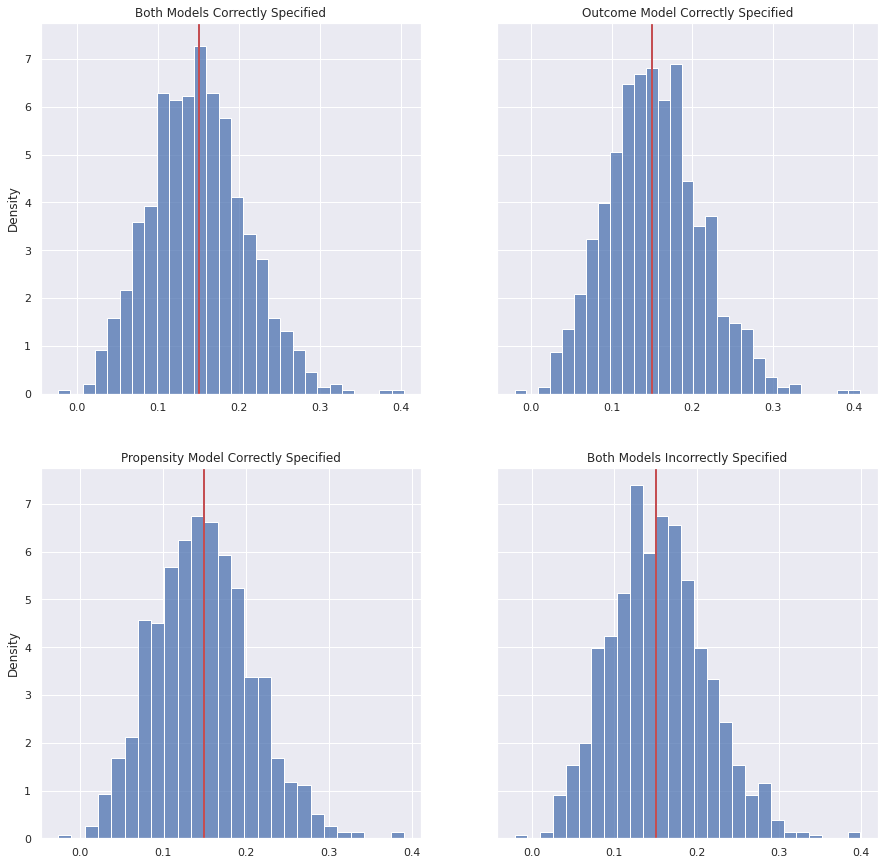

In [ ]:
sns.set(rc={'figure.figsize':(15,15)})
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=True)

sns.histplot(data=ATE_results_G_G,
             stat="density",
             ax=ax1)
ax1.set(title='Both Models Correctly Specified')
ax1.axvline(x=0.15,linewidth=2, color='r')

sns.histplot(data=ATE_results_G_B,
             stat="density",
             ax=ax2)
ax2.set(title='Outcome Model Correctly Specified')
ax2.axvline(x=0.15,linewidth=2, color='r')

sns.histplot(data=ATE_results_B_G,
             stat="density",
             ax=ax3)
ax3.set(title='Propensity Model Correctly Specified')
ax3.axvline(x=0.15,linewidth=2, color='r')

sns.histplot(data=ATE_results_B_B,
             stat="density",
             ax=ax4)
ax4.set(title='Both Models Incorrectly Specified')
ax4.axvline(x=0.15,linewidth=2, color='r')